In [64]:
import scipy
import scipy.sparse.linalg as linalg
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax.numpy.fft import fft, ifft, fftfreq
from jax import jit

from jax.config import config
config.update("jax_enable_x64", True)

# simulation grid
nu = 1
L = 35
nx = 1024//4
nt = 4000//4

# initial conditions used for demo
T  = 300
x = np.linspace( 0, L,  nx)
u0 = np.cos((2 * np.pi * x) / L) + 0.1 * np.cos((4 * np.pi * x) / L)

simulation_params = {'nu': nu, 'L': L, 'nx': nx, 'nt': nt}

# plot the result
def plot_KS(u,T,nx=nx,nt=nt):
    x = np.linspace( 0, L, nx)
    t = np.linspace( 0, T, nt)
    fig, ax = plt.subplots(figsize=(10,8))

    xx, tt = np.meshgrid(x, t)
    levels = np.linspace(-3.5, 3.5, 300)
    cs = ax.contourf(xx, tt, u, levels)
    fig.colorbar(cs)

    ax.set_xlabel("x")
    ax.set_ylabel("t")
    ax.set_title(f"Kuramoto-Sivashinsky: L = {L}, nu = {nu}")

In [65]:
def construct_integrator(nu, L, nx, nt):
  @jit
  def propagator(u0, T):
    dt = T/nt
    # wave number mesh (multiply back by nx because fftfreq takes it out - we raise k to powers so it affects us and has to be accounted for)
    k = (2 * jnp.pi / L) * fftfreq(nx) * nx

    # solution mesh in real and Fourier space
    u      = jnp.empty((nt, nx), dtype=jnp.float64)
    u_hat  = jnp.empty((nt, nx), dtype=jnp.complex128)
    u_hat2 = jnp.empty((nt, nx), dtype=jnp.complex128)

    # set initial condition in real and Fourier space
    u      = u     .at[0].set( u0 )
    u_hat  = u_hat .at[0].set( (1 / nx) * fft(u[0])    )
    u_hat2 = u_hat2.at[0].set( (1 / nx) * fft(u[0]**2) )

    # Fourier Transform of the linear and nonlinear operators
    FL = (k ** 2) - nu * (k ** 4)
    FN = - (1 / 2) * (1j) * k

    # Crank-Nicholson algebraic relations between uhat[n+1] and uhat[n]
    CN1 = (1 + (dt / 2) * FL)
    CN2 = 1 / (1 - (dt / 2) * FL)

    # first timestep (no advanced restarting, just Euler)
    u_hat  = u_hat .at[1].set( CN2 * ( CN1 * u_hat[0] + FN * u_hat2[0] * dt) )

    # auxiliaries of first timestep
    u      = u     .at[1].set( nx * jnp.real(ifft(u_hat[1])) )
    u_hat2 = u_hat2.at[1].set( (1 / nx) * fft(u[1]**2)       )

    # compute solution through time via finite difference method in Fourier space
    def finite_step(j, state):
        u, u_hat, u_hat2 = state
        # Cranck-Nicholson + Adams-Bashforth
        u_hat  = u_hat.at[j+1].set( CN2 * ( CN1 * u_hat[j] + ( 1.5 * FN * u_hat2[j] - 0.5 * FN * u_hat2[j-1] ) * dt) )
        
        # go back to real space
        u      = u     .at[j+1].set( nx * jnp.real(ifft(u_hat[j+1])) )
        u_hat2 = u_hat2.at[j+1].set( (1 / nx) * fft(u[j+1]**2)       )
        return (u, u_hat, u_hat2)

    # compute solution through time via finite difference method in Fourier space
    u = jax.lax.fori_loop(1,nt-1,finite_step,(u, u_hat, u_hat2))[0]
    return jnp.real(u)
  
  return propagator

JAX_propagator = construct_integrator(**simulation_params)
u = JAX_propagator(u0,T)

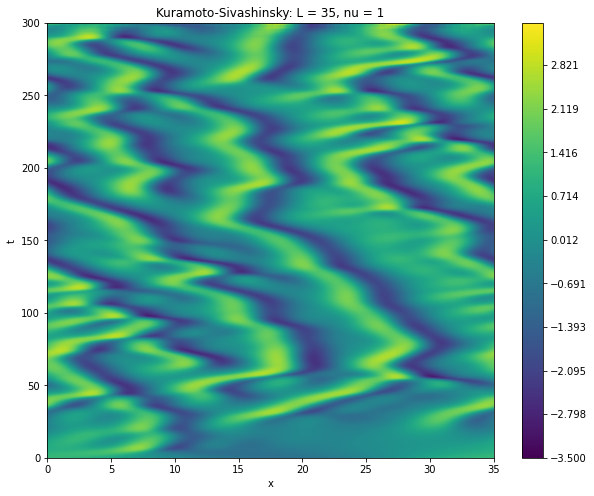

In [66]:
plot_KS(u,T)

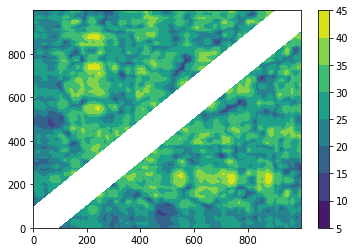

In [67]:
diff = np.linalg.norm(u[:,np.newaxis] - u[np.newaxis,:],axis=-1)
x, y = np.mgrid[0:1:(1j*nt),0:1:(1j*nt)]
diff[abs(x-y)<0.1] += np.inf
plt.contourf(diff)
plt.colorbar()

7.654376833146577
550 727


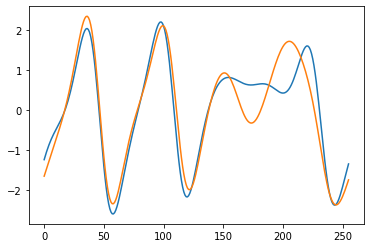

In [68]:
a = np.argmin(diff) % nt
b = np.argmin(diff) // nt
a, b = min(a,b), max(a,b)
plt.plot(u[a])
plt.plot(u[b])
print(np.linalg.norm(u[a] - u[b]))
print(a,b)

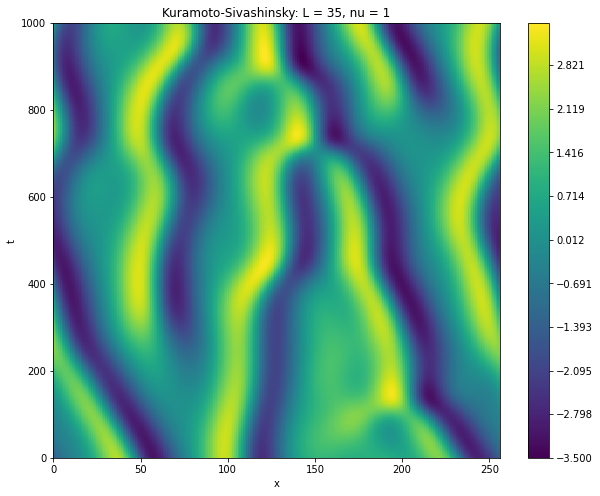

In [69]:
new_T = T * (b-a)/nt
u_new = JAX_propagator(u[a],new_T)
plot_KS(u_new, new_T)
plt.pcolor(u_new)

10.658983169580724
498 598


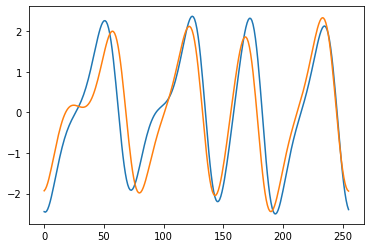

In [70]:
diff = np.linalg.norm(u_new[:,np.newaxis] - u_new[np.newaxis,:],axis=-1)
x, y = np.mgrid[0:1:(1j*nt),0:1:(1j*nt)]
diff[abs(x-y)<0.1] += np.inf
a = np.argmin(diff) % nt
b = np.argmin(diff) // nt
a, b = min(a,b), max(a,b)
plt.plot(u_new[a])
plt.plot(u_new[b])
print(np.linalg.norm(u_new[a] - u_new[b]))
print(a,b)

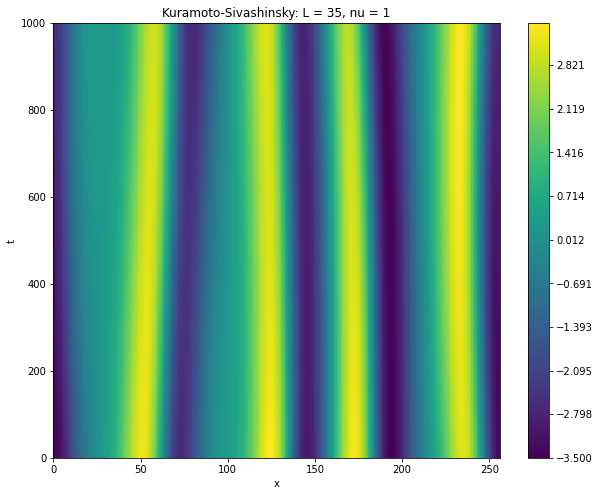

In [71]:
new_T *= (b-a)/nt
u_new = JAX_propagator(u_new[a],new_T)
plot_KS(u_new, new_T)
plt.pcolor(u_new)

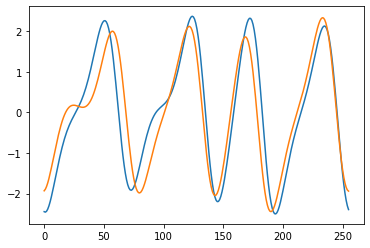

In [72]:
plt.plot(u_new[0])
plt.plot(u_new[-1])

In [73]:
@jit
def residual(state):
    T, u0 = state[0], state[1:]
    prop  = JAX_propagator(u0,T)
    state = jnp.zeros((u0.shape[0] + 1,))
    state = state.at[0].set(0)
    state = state.at[1:].set(prop[0] - prop[-1])
    return state

def State(u0, T):
    state = jnp.zeros((u0.shape[0] + 1,))
    state = state.at[0].set(T)
    state = state.at[1:].set(u0)
    return state

In [74]:
@jit
def residual(u0):
    return u0 - JAX_propagator(u0,new_T)[-1]

In [75]:
def JAX_newton_krylov(res, u0, tol=1e-5, iter=200):
    u = u0
    Jacobian_shape = (len(u0.flatten()), len(u0.flatten()))

    F = res(u)
    magF = np.linalg.norm(F)
    print(f"|F(x)| = {magF}")
    i = 1
    while magF > tol and i < iter:
        J = linalg.LinearOperator(Jacobian_shape, matvec=lambda v: (jax.jvp(res, (u.flatten(),), (v,)))[1])
        f, e = linalg.lgmres(J,F.flatten(),inner_m=40,outer_k=20)
        step = f.reshape(u.shape) * 0.01
        step = step if np.linalg.norm(step) < 0.01 * np.linalg.norm(u) else 0.01 * np.linalg.norm(u) * step / np.linalg.norm(step)
        u -= step
        F = res(u)
        magF = np.linalg.norm(F)
        print(f"{i}: |F(x)| = {magF:.10f}, |step| = {np.linalg.norm(step):.5f}, |u| = {np.linalg.norm(u):.5f}")
        i += 1
    return u

# solve
guess = u_new[0] #State(u[a],new_T)
sol = JAX_newton_krylov(residual, guess)
print('Residual', abs(residual(sol)).max())

|F(x)| = 10.650573583622181


C:\Users\kowal\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:11: DeprecationWarning: scipy.sparse.linalg.lgmres called without specifying `atol`. The default value will change in the future. To preserve current behavior, set ``atol=tol``.
  # This is added back by InteractiveShellApp.init_path()


1: |F(x)| = 10.5440367546, |step| = 0.08676, |u| = 23.42071
2: |F(x)| = 10.4385735363, |step| = 0.08535, |u| = 23.41624
3: |F(x)| = 10.3341725503, |step| = 0.08400, |u| = 23.41148


KeyboardInterrupt: 

In [ ]:
RPO = JAX_propagator(sol,new_T)

5.3100000000000005


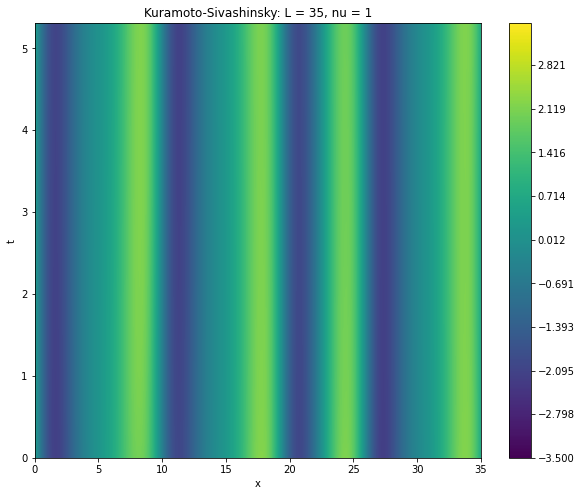

In [ ]:
print(new_T)
plot_KS(RPO, new_T)

In [ ]:
diff = sol[1:] - JAX_propagator(sol[1:], 50)[-1]
res = residual(sol)
print(np.linalg.norm(diff))
print(np.linalg.norm(res))
print(np.linalg.norm(res[1:]-diff))

ValueError: Incompatible shapes for broadcasting: (255,) and requested shape (256,)

In [ ]:
rpo_diff = sol[1:] - RPO[-1]
print(np.linalg.norm(res[1:]-rpo_diff))

nan


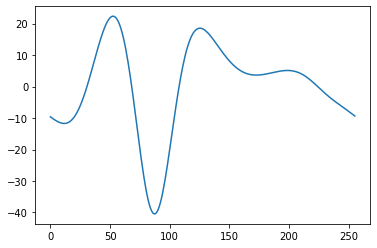

In [ ]:
plt.plot(sol[1:])
plt.plot(RPO[-1])